# Simple generation of locally constrained values in `numpyro`

Just a simple experiment using `numpyro` to simulate values from a function with locally constrained values. This is often achieved using Gaussian processed but I thought it would be interesting to try something a bit more intuitive, plus priors on the points themselves and their interdependence can be anything, not just normal distributions.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro.distributions as dist
import seaborn as sns
from numpyro import sample
from numpyro.infer import MCMC, NUTS

sns.set_theme('talk', 'ticks', font='Arial')

plt.rcParams['figure.dpi'] = 150

First, baseline: Independent draws from a normal distribution.

sample: 100%|██████████| 1100/1100 [00:00<00:00, 1787.68it/s, 7 steps of size 4.46e-01. acc. prob=0.86]


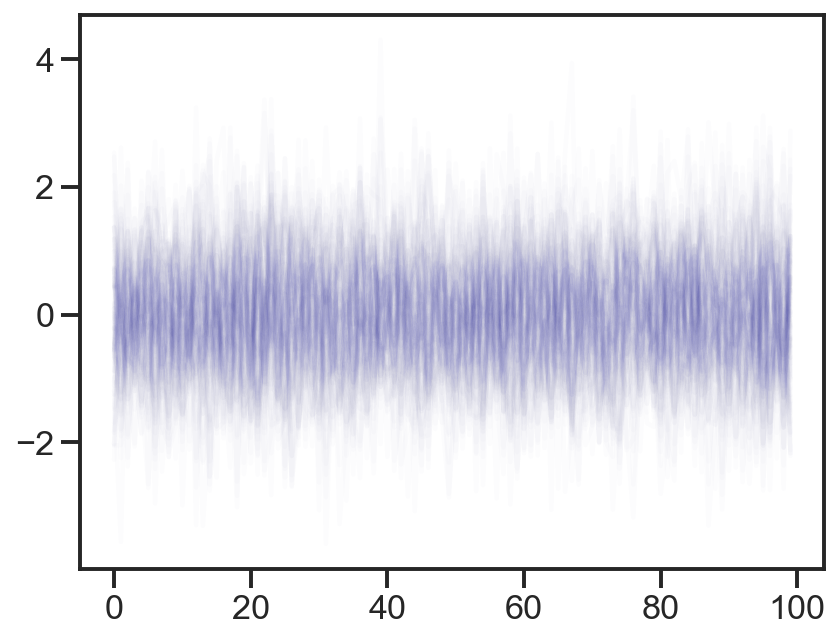

In [2]:
def model1():
    x = sample('x', dist.Normal().expand([100]))


mcmc = MCMC(NUTS(model1), num_warmup=1000, num_samples=100)
mcmc.run(jax.random.PRNGKey(0))
samples = mcmc.get_samples()

plt.plot(samples['x'].T, color='darkblue', alpha=0.01);

Adding some point observations ...

sample: 100%|██████████| 1100/1100 [00:00<00:00, 1529.03it/s, 15 steps of size 4.02e-01. acc. prob=0.90]


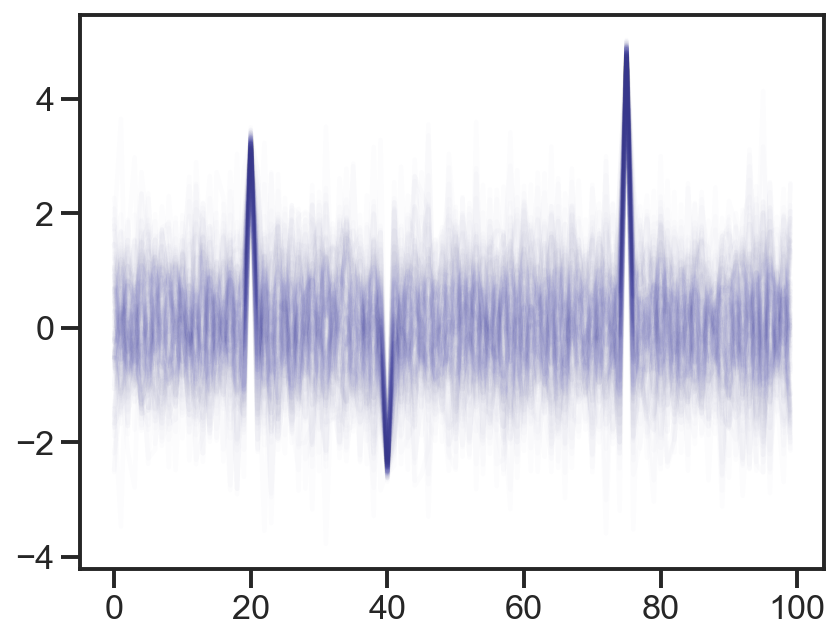

In [3]:
obs_vals = jnp.array([3.3, -2.5, 4.9])
obs_idx = jnp.array([20, 40, 75])

def model2(obs_vals, obs_idx):
    x = sample('x', dist.Normal().expand([100]))
    sample('x_point_obs', dist.Normal(loc=obs_vals, scale=0.1), obs=x[obs_idx])


mcmc = MCMC(NUTS(model2), num_warmup=1000, num_samples=100)
mcmc.run(jax.random.PRNGKey(0), obs_vals, obs_idx)
samples = mcmc.get_samples()

plt.plot(samples['x'].T, color='darkblue', alpha=0.01);

"Observing" each point to be the average of previous and following points. This would be equivalent to adjusting the log-likelihood or adding a potential in other packages.

sample: 100%|██████████| 1100/1100 [00:01<00:00, 1033.71it/s, 63 steps of size 8.62e-02. acc. prob=0.84]


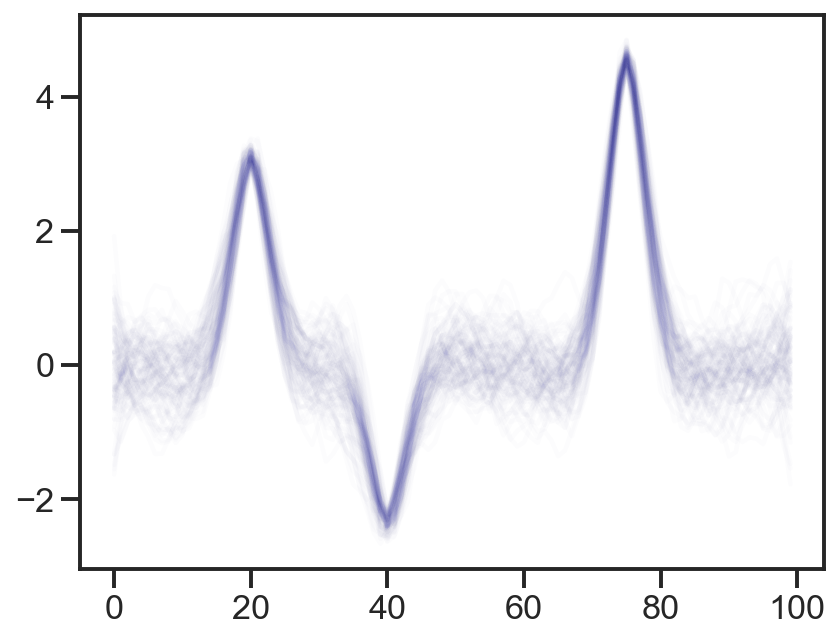

In [4]:
def model3(obs_vals, obs_idx):
    x = sample('x', dist.Normal().expand([100]))
    sample('x_dependence', dist.Normal(loc=(x[:-2]+x[2:])/2.0, scale=0.1), obs=x[1:-1])
    sample('x_point_obs', dist.Normal(loc=obs_vals, scale=0.1), obs=x[obs_idx])


mcmc = MCMC(NUTS(model3), num_warmup=1000, num_samples=100)
mcmc.run(jax.random.PRNGKey(0), obs_vals, obs_idx)
samples = mcmc.get_samples()

plt.plot(samples['x'].T, color='darkblue', alpha=0.01);

Slightly fancier — weighted relation to next/previous 2 points. I don't notice a dramatic change with this 1:2:2:1 weighting but it would be interesting to add asymmetric constraints, etc. I suppose this could be useful for probabilistic low-pass filtering with sinc weights.

sample: 100%|██████████| 1100/1100 [00:01<00:00, 926.95it/s, 63 steps of size 9.88e-02. acc. prob=0.89] 


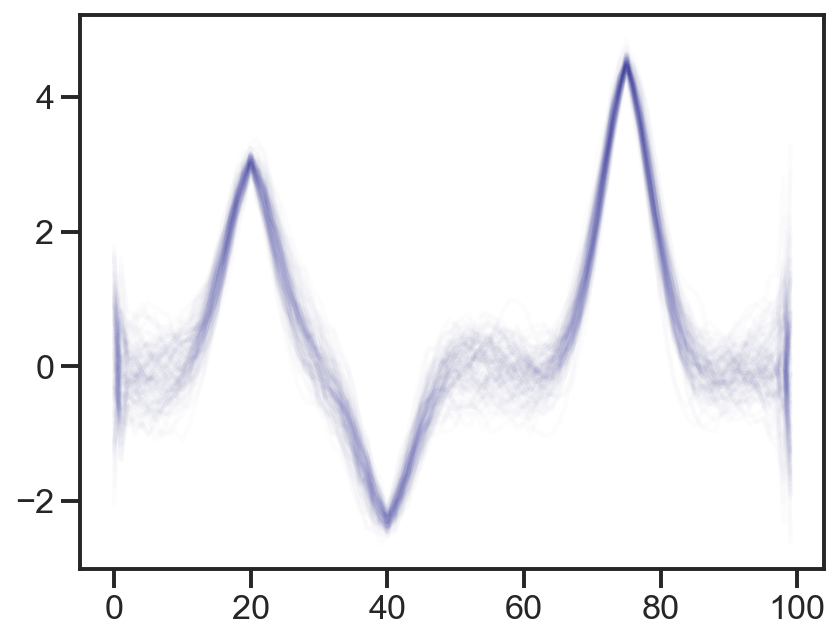

In [5]:
def model4(obs_vals, obs_idx):
    x = sample('x', dist.Normal().expand([100]))
    sample('x_pre_obs', dist.Normal(loc=(x[:-4]+2.0*x[1:-3]+2.0*x[3:-1]+x[4:])/6.0, scale=0.1), obs=x[2:-2])
    sample('x_point_obs', dist.Normal(loc=obs_vals, scale=0.1), obs=x[obs_idx])


mcmc = MCMC(NUTS(model4), num_warmup=1000, num_samples=100)
mcmc.run(jax.random.PRNGKey(0), obs_vals, obs_idx)
samples = mcmc.get_samples()

plt.plot(samples['x'].T, color='darkblue', alpha=0.01);

Something a bit more interesting. Let's change the "base" distribution to be bimodal and asymmetric. I have picked fairly broad humps so we have a fair shot at achieving good mixing.

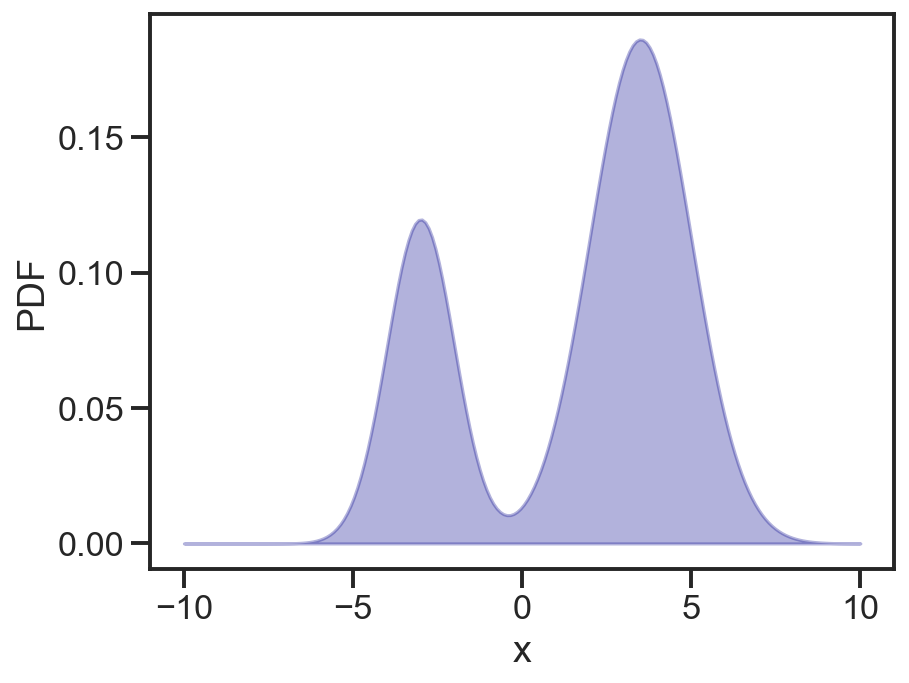

In [6]:
mixing_distribution = dist.Categorical(jnp.array([0.3, 0.7]))
component_distribution = dist.Normal(
    loc=jnp.array([-3.0, 3.5]), scale=jnp.array([1.0, 1.5])
)

d = dist.MixtureSameFamily(mixing_distribution, component_distribution)

x = jnp.linspace(-10, 10, 200)
y = np.exp(d.log_prob(x))

plt.fill_between(x, y, alpha=0.3, color='darkblue')
plt.gca().set(xlabel='x', ylabel='PDF');

sample: 100%|██████████| 1200/1200 [00:00<00:00, 1606.27it/s, 15 steps of size 1.68e-01. acc. prob=0.83]


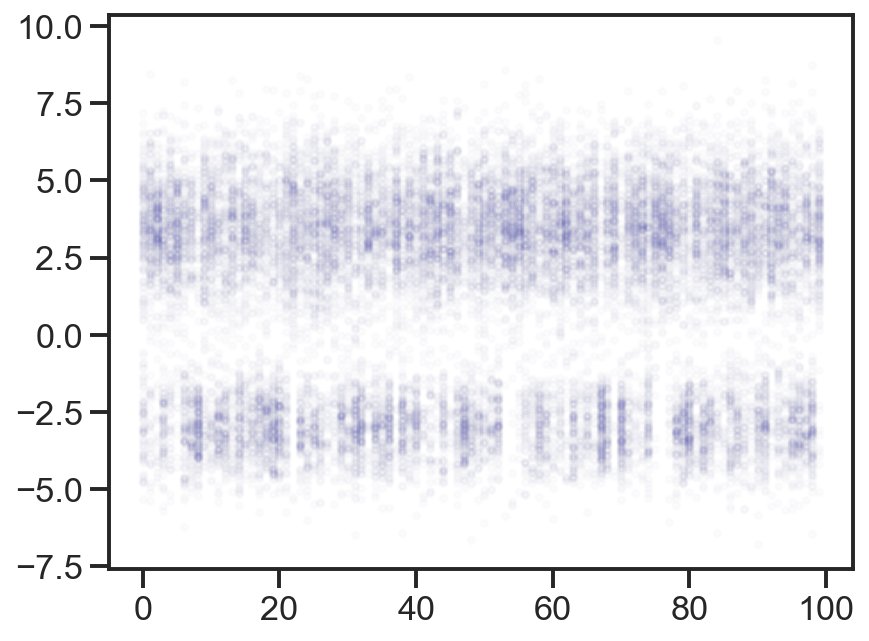

In [7]:
def model5(obs_vals, obs_idx):
    x = sample('x', d.expand([100]))

mcmc = MCMC(NUTS(model5), num_warmup=1000, num_samples=200)
mcmc.run(jax.random.PRNGKey(0), obs_vals, obs_idx)
samples = mcmc.get_samples()

x_points = np.repeat(np.arange(100)[None, :], samples['x'].shape[0], axis=0)
plt.scatter(x_points.flatten(), samples['x'].flatten(), color='darkblue', alpha=0.01, s=10);

Adding back the observation constraints without dependence.

sample: 100%|██████████| 1200/1200 [00:00<00:00, 1439.87it/s, 15 steps of size 1.48e-01. acc. prob=0.87]


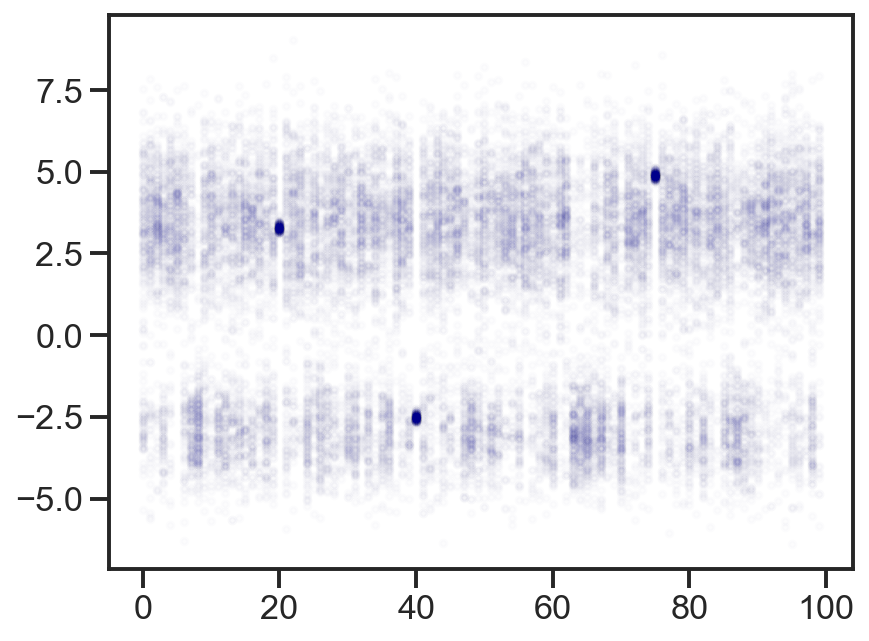

In [8]:
def model6(obs_vals, obs_idx):
    x = sample('x', d.expand([100]))
    sample('x_point_obs', dist.Normal(loc=obs_vals, scale=0.1), obs=x[obs_idx])

mcmc = MCMC(NUTS(model6), num_warmup=1000, num_samples=200)
mcmc.run(jax.random.PRNGKey(0), obs_vals, obs_idx)
samples = mcmc.get_samples()

x_points = np.repeat(np.arange(100)[None, :], samples['x'].shape[0], axis=0)
plt.scatter(x_points.flatten(), samples['x'].flatten(), color='darkblue', alpha=0.01, s=10);

Finally, bringing back dependency on adjacent points ...

sample: 100%|██████████| 1200/1200 [00:03<00:00, 325.35it/s, 255 steps of size 2.30e-02. acc. prob=0.88]


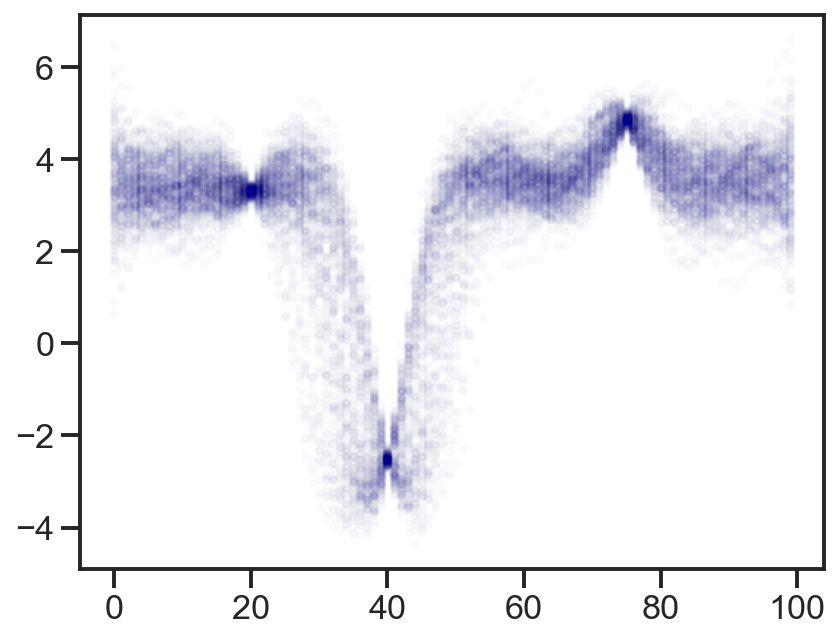

In [9]:
def model6(obs_vals, obs_idx):
    x = sample('x', d.expand([100]))
    sample('x_dependence', dist.Normal(loc=(x[:-2]+x[2:])/2.0, scale=0.1), obs=x[1:-1])
    sample('x_point_obs', dist.Normal(loc=obs_vals, scale=0.1), obs=x[obs_idx])

mcmc = MCMC(NUTS(model6), num_warmup=1000, num_samples=200)
mcmc.run(jax.random.PRNGKey(0), obs_vals, obs_idx)
samples = mcmc.get_samples()

x_points = np.repeat(np.arange(100)[None, :], samples['x'].shape[0], axis=0)
plt.scatter(x_points.flatten(), samples['x'].flatten(), color='darkblue', alpha=0.01, s=10);

And now just for fun, let's try a bimodal dependency distribution, here essentially saying that each point is likely to be larger than its neighbor (or linger in the same ballpark).

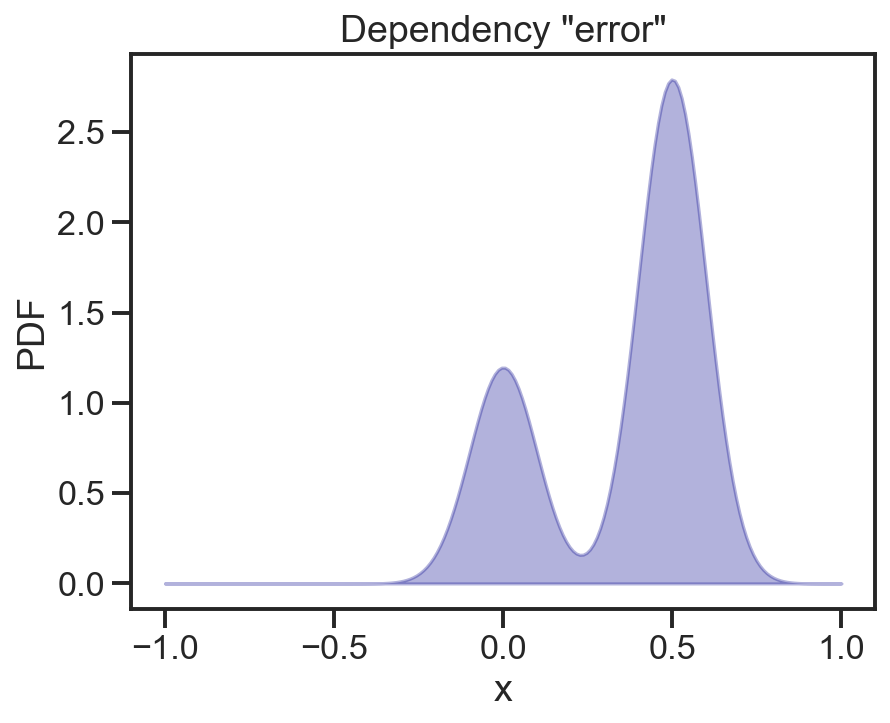

In [10]:
d_dep = dist.MixtureSameFamily(
    mixing_distribution,
    dist.Normal(loc=jnp.array([0, 0.5]), scale=0.1)
)

# plot PDF
x = jnp.linspace(-1, 1, 200)
y = np.exp(d_dep.log_prob(x))

plt.fill_between(x, y, alpha=0.3, color='darkblue')
plt.gca().set(xlabel='x', ylabel='PDF', title='Dependency "error"');

sample: 100%|██████████| 1200/1200 [00:03<00:00, 375.87it/s, 127 steps of size 6.49e-02. acc. prob=0.84]


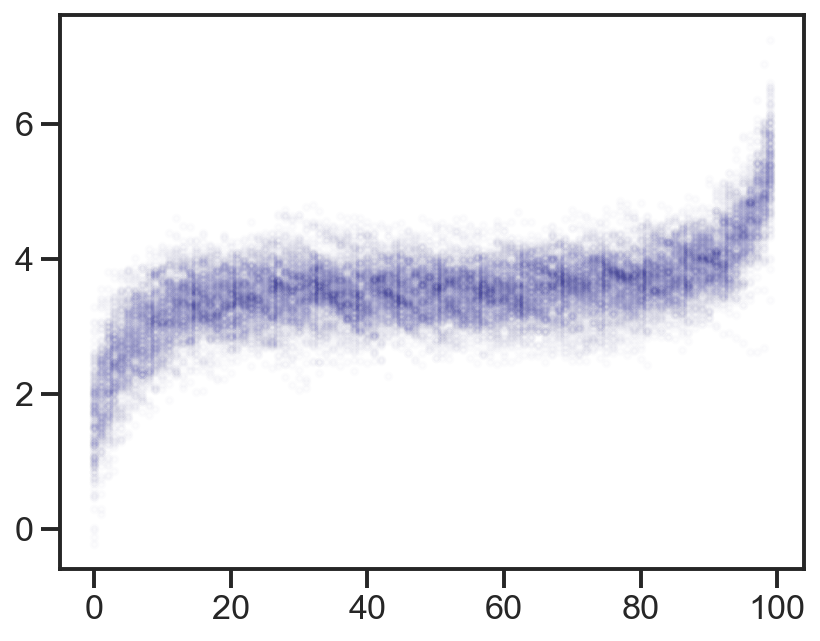

In [11]:
def model7(obs_vals, obs_idx):
    x = sample('x', d.expand([100]))
    sample('x_dependence', d_dep, obs=x[1:] - x[:-1])

mcmc = MCMC(NUTS(model7), num_warmup=1000, num_samples=200)
mcmc.run(jax.random.PRNGKey(0), obs_vals, obs_idx)
samples = mcmc.get_samples()

x_points = np.repeat(np.arange(100)[None, :], samples['x'].shape[0], axis=0)
plt.scatter(x_points.flatten(), samples['x'].flatten(), color='darkblue', alpha=0.01, s=10);

With the observations added back in:

sample: 100%|██████████| 1200/1200 [00:02<00:00, 493.73it/s, 255 steps of size 5.76e-02. acc. prob=0.88]


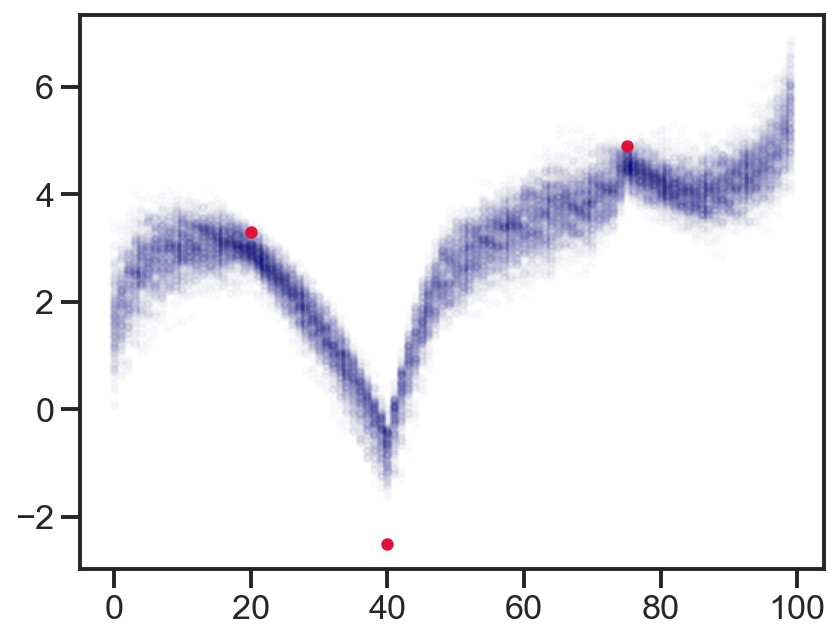

In [12]:
def model8(obs_vals, obs_idx):
    x = sample('x', d.expand([100]))
    sample('x_dependence', d_dep, obs=x[1:] - x[:-1])
    sample('x_point_obs', dist.Normal(loc=obs_vals, scale=0.25), obs=x[obs_idx])

mcmc = MCMC(NUTS(model8), num_warmup=1000, num_samples=200)
mcmc.run(jax.random.PRNGKey(0), obs_vals, obs_idx)
samples = mcmc.get_samples()

x_points = np.repeat(np.arange(100)[None, :], samples['x'].shape[0], axis=0)
plt.scatter(x_points.flatten(), samples['x'].flatten(), color='darkblue', alpha=0.01, s=10)
plt.scatter(obs_idx, obs_vals, label='observed values', color='crimson', s=20);

Very cool and I think quite useful for modelling chromatograms.